###Survival Analysis

* This notebook is about the application of Survival Analysis in cricket - to analyze the career lengths of players.

* Survival Analysis has been described in length by various resources, the following are the major soruces I used to
understand the concept:
    * Allen B. Downy's book on exploratory data analysis in Python includes a great chapter on survival curves, hazard functions, Kaplan–Meier estimators etc. 
    
    http://greenteapress.com/thinkstats2/thinkstats2.pdf 
    
    * Econometrics Academy's notes on survival analysis http://sites.google.com/site/econometricsacademy/econometrics-models/survival-analysis
     
    * Cam Davidson-Pilon's documentation on the lifelines python library on survival analysis.
    
         http://lifelines.readthedocs.org/en/latest/Quickstart.html

* Survival Analyis is used in areas where the time duration of a sample of observations is analysed until an event of death occurs.
* This has great use in mechanical engineering where the lifetime of a tool/product is analyzed, medical sciences where 
the lifetime of cancer patients is analyzed etc.
* This is an attempt to extend this statistical concept into the field of cricket - to analyze the career lengths of players.

* The event of death in this case is the event when players retire from active cricket.
* I have tried to analyze all the players who have played ODI cricket. 
* The reason Test cricket wasn't chosen is due to the fact there is too much noise in the data due to the careers of the players marred due to the World Wars, Apartheid Crisis, Kerry Packer's cricket series etc.

- There isn't any readily available data when it comes to cricket yet - ESPNCricinfo still doesn't provide an API to use its StatsGuru database machine - so I had to scrape the data from the Statsguru webpages to acquire the data.

In [4]:
%matplotlib inline
from bs4 import BeautifulSoup
import requests
import pandas as pd
import lifelines
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

#### Scraping
The following method scrapes the required data from the webpages. 

In [14]:
statsguru_query_url = 'http://stats.espncricinfo.com/ci/engine/stats/index.html?class=2;filter=advanced;orderby=runs;page=1;size=200;template=results;type=batting'

In [15]:
def scrape_data(page_count):
    """
    scrapes the required data present in the form of a table from the given url
    :param url: page of the ESPNCricinfo Stats URL query
    :return: the raw unicode text
    """
    url = statsguru_query_url
    complete_url = url.partition('page=1')[0] + "page=" + str(page_count) + url.partition('page=1')[-1]
    r = requests.get(complete_url)
    data = r.text
    soup = BeautifulSoup(data)
    table = soup.find_all('table')
    return table[2].text

#### Data Cleaning
Once the data is scraped, it has to be cleaned - stripping of the whitespaces and other noisy data to get it into a proper structure

In [16]:
def clean_data(text):
    """
    cleans the data removing all whitespaces and other data
    :param text: table text of each page
    :return: cleaned text  
    """
    text = text.split('\n')
    text.remove(u'Overall figures')
    return text

#### Data Transformation
The data is now transformed accordingly to make get the data into a structure with which it can effectively be modelled.
A series of methods and transformations are done to make a dataframe, fit for modelling.

In [73]:
def create_data():
    """
    scrapes the data, cleans it and transforms the data to load into a pandas dataframe
    """
    page_count = 12
    df = pd.DataFrame()
    get_list_columns = lambda text, start_index, end_index: [str(unicode_text)
                                                                for unicode_text in text][start_index:end_index]
    get_data_rows = lambda text, start_index: text[start_index:]
    remove_all_occurences = lambda data, item: [x for x in data if x != item]
    get_list_rows = lambda data: [data[index: index + 13] for index, row in enumerate(data) if index % 13 == 0]
    for page in range(1, page_count + 1):
        raw_text = scrape_data(page)
        clean_text = clean_data(raw_text)
        list_columns = get_list_columns(clean_text, 3, 16)
        data_rows = get_data_rows(clean_text, 16)
        data_rows = remove_all_occurences(data_rows, u'')
        list_rows = get_list_rows(data_rows)
        df_new = pd.DataFrame(list_rows, columns=list_columns)
        if len(df) == 0:
            df = df_new
        else:
            df = pd.concat([df, df_new])
    return df

In [21]:
df_full = create_data()
df_full = df_full.reset_index(drop=True)

* The scraped data is stored in the form of a pandas dataframe.

In [75]:
len(df_full)

2244

* There are totally 2244 players who have played ODI cricket since its inception in the 1970s.

* The following displays the first five rows of the data.
* The data is by default sorted by the amount of runs scored.

In [76]:
df_full.head()

,player,span,mat,inns,not_outs,runs,high_score,ave,bf,sr,n_100,n_50,n_0
0,SR Tendulkar (India),1989-2012,463,452,41,18426,200*,44.83,21367,86.23,49,96,20
1,KC Sangakkara (Asia/ICC/SL),2000-2015,404,380,41,14234,169,41.98,18048,78.86,25,93,15
2,RT Ponting (Aus/ICC),1995-2012,375,365,39,13704,164,42.03,17046,80.39,30,82,20
3,ST Jayasuriya (Asia/SL),1989-2011,445,433,18,13430,189,32.36,14725,91.20,28,68,34
4,DPMD Jayawardene (Asia/SL),1998-2015,448,418,39,12650,144,33.37,16020,78.96,19,77,28


Renaming the columns to access them easier

In [82]:
df_full.columns = ['player', 'span', 'mat', 'inns', 'not_outs', 'runs', 'high_score', 'ave', 'bf', 'sr', 'n_100', 'n_50', 'n_0']

Extracting only two columns - the name of the player and the span(duration of career) from the original dataframe

In [214]:
df_span = df_full[['player','span']]

In [215]:
df_span.head()

,player,span
0,SR Tendulkar (India),1989-2012
1,KC Sangakkara (Asia/ICC/SL),2000-2015
2,RT Ponting (Aus/ICC),1995-2012
3,ST Jayasuriya (Asia/SL),1989-2011
4,DPMD Jayawardene (Asia/SL),1998-2015


Adding two new columns - career_start_date and career_end_date, both created from the column span

In [216]:
# disables warning
pd.options.mode.chained_assignment = None
df_span['career_start_date'] = [int(span.partition('-')[0]) for span in df_span.span]
df_span['career_end_date'] = [int(span.partition('-')[-1]) for span in df_span.span]

In [217]:
df_span.head()

,player,span,career_start_date,career_end_date
0,SR Tendulkar (India),1989-2012,1989,2012
1,KC Sangakkara (Asia/ICC/SL),2000-2015,2000,2015
2,RT Ponting (Aus/ICC),1995-2012,1995,2012
3,ST Jayasuriya (Asia/SL),1989-2011,1989,2011
4,DPMD Jayawardene (Asia/SL),1998-2015,1998,2015


Adding another column - 'career_length' which is obtained from subtracting the above two columns

In [218]:
calc_career_length = lambda df: [row.career_end_date - row.career_start_date + 1 for index, row in df.iterrows()]
df_span['career_length'] = calc_career_length(df_span)

In [219]:
df_span.head()

,player,span,career_start_date,career_end_date,career_length
0,SR Tendulkar (India),1989-2012,1989,2012,24
1,KC Sangakkara (Asia/ICC/SL),2000-2015,2000,2015,16
2,RT Ponting (Aus/ICC),1995-2012,1995,2012,18
3,ST Jayasuriya (Asia/SL),1989-2011,1989,2011,23
4,DPMD Jayawardene (Asia/SL),1998-2015,1998,2015,18


The country of the player has not been represented, though it has been included within the player's name. Having 
the country as a column can be quite useful.

In [220]:
get_name = lambda player : [each_player.partition(' (')[0] for each_player in player]
df_span['name'] = get_name(df_span.player)

In [221]:
get_country = lambda player: [each_player[each_player.index('(')+1:each_player.index(')')] for each_player in player]
df_span['country'] = get_country(df_span.player)

* Certain players however have played for more than 1 team - Asia/ ICC etc. Such countries don't make any change and
have to be removed.
* Certain players like Kepler Wessels, Eoin Morgan have played for more than 1 country - for sake of simplicity, 
such players are ignored as their career lengths will be longer - forming outliers.

In [222]:
remove_forward_slash = lambda country: [each_country.replace('/', '') for each_country in country]
df_span['country'] = remove_forward_slash(df_span.country)

Considering players belonging to the 'Full members' of ICC as the associate countries' data may be noisy, creating outliers

In [223]:
list_countries = lambda country : ['India' if 'India' in each_country
                 else 'SL' if 'SL' in each_country
                 else 'SA' if 'SA' in each_country
                 else 'Aus' if 'Aus' in each_country
                 else 'Pak' if 'Pak' in each_country
                 else 'WI' if 'WI' in each_country
                 else 'NZ' if 'NZ' in each_country
                 else 'Zim' if 'Zim' in each_country
                 else 'Eng' if 'Eng' in each_country
                 else 'Ban' if 'Ban' in each_country
                 else None for each_country in country]
df_span['country'] =  list_countries(df_span.country)

In [224]:
df_span = df_span[df_span.country.notnull()]

In [226]:
df_span.head()

,player,span,career_start_date,career_end_date,career_length,name,country
0,SR Tendulkar (India),1989-2012,1989,2012,24,SR Tendulkar,India
1,KC Sangakkara (Asia/ICC/SL),2000-2015,2000,2015,16,KC Sangakkara,SL
2,RT Ponting (Aus/ICC),1995-2012,1995,2012,18,RT Ponting,Aus
3,ST Jayasuriya (Asia/SL),1989-2011,1989,2011,23,ST Jayasuriya,SL
4,DPMD Jayawardene (Asia/SL),1998-2015,1998,2015,18,DPMD Jayawardene,SL


Dropping columns 'player' and 'span' from the dataframe

In [227]:
df_span = df_span.drop('player', 1)

In [228]:
df_span = df_span.drop('span', 1)

Reordering the columns

In [229]:
df_span = df_span[['name', 'country', 'career_start_date', 'career_end_date', 'career_length']]

In [230]:
df_span.head()

,name,country,career_start_date,career_end_date,career_length
0,SR Tendulkar,India,1989,2012,24
1,KC Sangakkara,SL,2000,2015,16
2,RT Ponting,Aus,1995,2012,18
3,ST Jayasuriya,SL,1989,2011,23
4,DPMD Jayawardene,SL,1998,2015,18


#### Censoring the data

* While analyzing the durations of a sample/population, it is quite possible to find certain individuals or data 
    whose death has not occured yet - at the current time, their deaths have not yet been noticed/occured.
* When the data has this behaviour, it is said to be *right-censored*.
* It is crucial to include the censored data before modelling, as having only the non-censored data can imply different observations about the data which need not be true.
* Indeed, data for survival analysis can be viewed as a regression dataset where the outcome variable - 'censor' 
    is not defined for few rows.

#### Censoring in cricket

* The event of '**death**' in this example is the event of players retiring from active cricket (ODI).
* So there are players who have not yet retired yet - who are still playing some form of active cricket or have died 
    unfortunately - Phil Hughes for instance.
* These players form the censored data in this case.
* Again, Statsguru does not provide any easy way of finding out whether players have retired or not.
* For sake of this implementation of survival curves, I have *manually* entered the censoring label for each 
    of the players.
* In this effort, I have assumed that those players who last played in 2011 or earlier have retired.
* The reasons for choosing 2011 are multi-fold:
    1. It's 4 years since 2015 - there is a high chance that players who last played in 2011 have retired or will never play again. Yes, there may be exceptions. 
    2. 2011 is the year of the previous World Cup which saw a number of high-profile retirements and generally, players usually draw their careers to a close after a World Cup.
    3. One more world cup has ended after 2011 - this means that teams will ideally look to build towards the next world cup, meaning those who last played in 2011 will almost never get a chance to play again. This closely is interconnected with the first reason.

In [231]:
# entering 1 intially for all players
df_span['censor'] = [1 if each_player.career_end_date <= 2011 else 0 for index,each_player in df_span.iterrows()]

* censor label : 1 means that player has retired, 0 means that the player has an active playing career.

In [237]:
#re-ordering index of dataframe
df_span.reset_index(drop=True);

In [238]:
# converting dataframe to csv to manually alter it
df_span.to_csv('censor.csv')

In [249]:
df_censor = pd.read_csv('censor.csv')

In [250]:
df_censor = df_censor.drop('Unnamed: 0', 1);

The following data shows few rows of the data with its censored values.

In [251]:
df_censor.tail(12)

,name,country,career_start_date,career_end_date,career_length,censor
1740,EP Thompson,NZ,2009,2009,1,1
1741,AL Thomson,Aus,1971,1971,1,1
1742,RW Tolchard,Eng,1979,1979,1,1
1743,CM Tuckett,WI,1998,1998,1,1
1744,I Udana,SL,2012,2012,1,0
1745,JD Unadkat,India,2013,2013,1,0
1746,JM Vince,Eng,2015,2015,1,0
1747,Wahidul Gani,Ban,1988,1988,1,1
1748,KP Walmsley,NZ,2003,2003,1,1
1749,M Watkinson,Eng,1996,1996,1,1


In [244]:
df_censor.censor.value_counts().sort_index()

0     365
1    1387
dtype: int64

* It is thus observed that there are 365 0-censor labelled players and 1387 1-censor labelled players in the dataset.

* In other words, there are 365 active players in ODI cricket - that is an average of around 37 players for every team, considering only 10 teams are considered - which sort of makes sense.

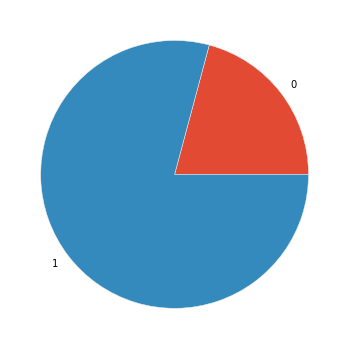

In [258]:
df_censor.censor.value_counts().sort_index().plot(kind='pie', figsize=(6, 6), ())